# How To Use The COSIMA CookBook

This notebook is designed to help new users get to grips with the COSIMA Cookbook. It assumes that:
 * You have cloned the cosima-cookbook git repository to a location that can see the COSIMA storage space on [NCI](http://cosima-cookbook.readthedocs.io/en/latest/nci.org.au) (/g/data3/hh5/tmp/cosima). We recommend the [Virtual Desktop Infrastructure (VDI)](http://nci.org.au/services/vdi/).
 * You have access to a python3 distribution with the required packages.
 * You have installed the cosima-cookbook package (via `pip install --user -e`).
 * You can fire up a Jupyter notebook!

**Before starting,** load in some libraries that you are likely to need:

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs

/home/157/amh157/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In addition, you **always** need to load the cosima_cookbook module. This provides a bunch of functions that you will use:

In [3]:
import cosima_cookbook as cc

netcdf_index loaded.


## 1. The CookBook Philosophy
The COSIMA Cookbook is a framework for analysing ocean-sea ice model output.
It is designed to:
* Provide a library of commonly used diagnostics;
* Write efficient, well-documented, openly accessible code;
* Encourage community input to the code;
* Ensure diagnostic results are reproducible;
* Find methods to deal with the memory limitations of analysing high-resolution model output.


### 1.1 A database of experiments
Assumes that we store data as:
* configuration, 
* experiment,
* output???
* netcdf files

In [ ]:
cc.build_index()

### 1.2 Inbuilt Database Functions

We have constructed a few functions to help you operate the cookbook and to access the datasets. These functions all sit in the `cosima_cookbook` directory. For example, `netcdf_index.py` contains the above `build_index` function as well as a series of functions that are built to query the SQL database.

`get_configuration` returns a list of all model configurations that are saved into the database. 

In [ ]:
cc.get_configurations()

`get_experiments` lists all of the experiments that are catalogued for a given configuration. These function needs one of the above configurations as an input.

In [ ]:
cc.get_experiments('access-om2')

`get_ncfiles` provides a list of all the netcdf filenames saved for a given experiment. Note that each of these filenames are present in some or all of the output directories.

In [ ]:
cc.get_ncfiles('025deg_jra55v13_ryf8485_spinup_A')

And finally, `get_variables` provides a list of all the variables available in a specific netcdf file. This functions requires both the experiment and the filename to be provided.

In [ ]:
cc.get_variables('025deg_jra55v13_ryf8485_spinup_A','ocean_month.nc')

### 1.3 Loading data from a netcdf file

Python has many ways of reading in data from a netcdf file ... so we thought we would add another way. This is achieved in the `get_nc_variable` function, which is the most commonly used function in the cookbook. This function queries the database to find a variable from a specific file, from a specific variable, and loads some or all of that file. We will now take a little while to get to know this function. In it's simplest form, you need just three arguments: expt, ncfile and variable:

In [ ]:
cc.get_nc_variable('025deg_jra55v13_ryf8485_spinup_A','ocean_scalar.nc','temp_global_ave')

You may like to note a few things about this function:
1. The data is returned as an xarray DataArray, which includes the coordinate and attribute information from the netcdf file (more on xarray later). 
2. The variable time does not start at zero (like the netcdf file) - we generally shift it to be in a data range that allows us to use `pandas` time series and date functionality.
3. By default, we load the whole dataset, but we could just load the last `n` netcdf files (useful for testing).
4. Other customisable options include setting the variable chunking and incorporating a function to operate on the data.
You can see all the avaiable options using the inbuilt help function, which brings up the function documentation.

In [ ]:
help(cc.get_nc_variable)

### 1.4 Exercises
OK, this is a tutorial, so now you have to do some work. Your tasks are to:
* Find and load SSH from an experiment (an experiment ... perhaps a 1° configuration would be best).

* Just load the last 10 files from an experiment (any variable you like).

* Load potential temperature from an experiment (again, 1° would be quickest). Can you chunk the data differently from the default?

## 2. How to manipulate and plot variables with xarray
We use the python package `xarray` (which is built on `dask`, `pandas`, `matplotlib` and `numpy`) for many of our diagnostics. `xarray` has a a lot of nice features, some of which we will try to demonstrate for you. 

### 2.1 Plotting
`xarray`'s `.plot()` command does its best to figure out what you are trying to plot, and plotting it for you. Let's start by loading a 1-dimensional variable and plotting.

HBox(children=(IntProgress(value=0, description='get_nc_variable:: '), HTML(value='')))

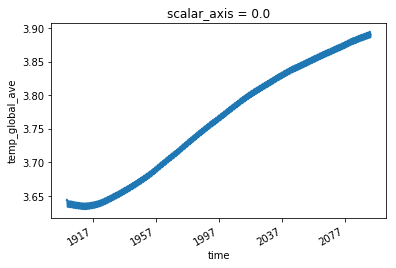

In [4]:
darray = cc.get_nc_variable('025deg_jra55v13_ryf8485_spinup_A','ocean_scalar.nc','temp_global_ave')
darray.plot()

You should see that `xarray` has figured out that this data is a timeseries, that the x-axis is representing time and that the y-axis is `temp_global_ave`. You can always modify aspects of your plot if you are unhappy with the default xarray behaviour:

In [ ]:
darray = cc.get_nc_variable('025deg_jra55v13_ryf8485_spinup_A','ocean_scalar.nc','temp_global_ave')
darray.plot()
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Globally Averaged Temperature')

Because `xarray` knows about dimensions, it has plotting routines which can figure out what it shold plot. For example, 

In [ ]:
darray = cc.get_nc_variable('025deg_jra55v13_ryf8485_spinup_A','ocean_month.nc','surface_temp',n=1)
darray.mean('time').plot()

Again, you can customise this plot as you see fit:

In [ ]:
darray = cc.get_nc_variable('025deg_jra55v13_ryf8485_spinup_A','ocean_month.nc','surface_temp',n=1)
darray = darray - 273.19
darray.mean('time').plot.contourf(levels=np.arange(-2,32,2),cmap=cm.cm.thermal)
plt.ylabel('latitude')
plt.xlabel('longitude')

### 2.2 Slicing and dicing

There are two different ways of subselecting from a dataarray: `isel` and `sel`. The first of these is probably what you are used to -- you specify the value of the index of the array. In the second case you specify the value of the coordinate you want to select. These two methods are demonstrated in the following example:

In [ ]:
darray = cc.get_nc_variable('1deg_jra55_ryf9091_kds50','ocean.nc','pot_rho_2',time_units='days since 1700-01-01')
surface_density = darray.isel(time=400).sel(st_ocean=1000,method='nearest')
surface_density.plot()

In the above example, a 450-year dataset is loaded. We then use `isel` to select the 401st year (time=400) and use `sel` to select a z level that is about 1000m deep. The `sel` method is very flexible, allowing us to use similar code in differing model resolutions or grids. In addition, both methods allow you to slice a range of values:

In [ ]:
darray = cc.get_nc_variable('025deg_jra55v13_ryf8485_spinup_A','ocean.nc','v',time_units='days since 1700-01-01')
v = darray.isel(time=100).sel(st_ocean=50,method='nearest')\
            .sel(yu_ocean=slice(-50,-20)).sel(xu_ocean=slice(-230,-180)).load()
v.plot()

Here we have taken meridional velocity, and sliced out a small region of interest for our plot. Note the `load()` command -- the point is that `xarray` aims to defer calculations until the variable is needed ...

### 2.3 Averaging along dimensions

We often perform operations such as averaging on dataarrays. Again, knowledge of the coordinates can be a big help here, as you can instruct the `mean` function to operate along given coordinates. The case below takes a temporal and zonal average of potential density. (NB, this function ignores the tripole in the Arctic.)

In [ ]:
darray = cc.get_nc_variable('1deg_jra55_ryf9091_kds50','ocean.nc','pot_rho_2',n=10,time_units='days since 1700-01-01')
darray.mean('time').mean('xt_ocean').plot(cmap=cm.cm.haline)
plt.gca().invert_yaxis()

### 2.4 Resampling

`xarray` uses `pandas datetime` conventions to allow for operations such as resampling in time. This resampling is simple and powerful but it has a major drawback: it only works for dates between about 1620 and 2400. Frankly, this limitation really sucks -- it prevents us from analysis simulations for longer than ~700 years, and means we need to set a date of 1700 (where ocean-sea ice models usually start from zero). Anyway, we still use it, and here is an example of re=plotting the figure from 2.1 with annual averaging:

HBox(children=(IntProgress(value=0, description='get_nc_variable:: '), HTML(value='')))

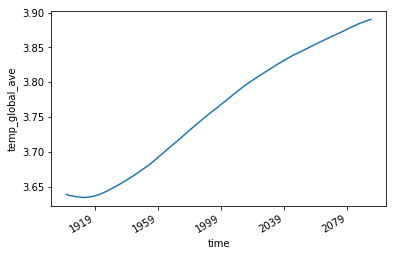

In [7]:
darray = cc.get_nc_variable('025deg_jra55v13_ryf8485_spinup_A','ocean_scalar.nc','temp_global_ave')
darray.resample(time='A').mean().plot()

### 2.5 Exercises

 * Pick an experiment and plot a map of the temperature of the upper 100m of the ocean for one year.

 * Now, take the same experiment and construct a timeseries of spatially averaged (regional or global) upper 700m temperature, resampled every 3 years.

## 3. More Advanced Stuff

### 3.1 Making a map with cartopy

HBox(children=(IntProgress(value=0, description='get_nc_variable:: ', max=1), HTML(value='')))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |
INFO:shapely.geos:Self-intersection at or near point -180 89.894483032447312


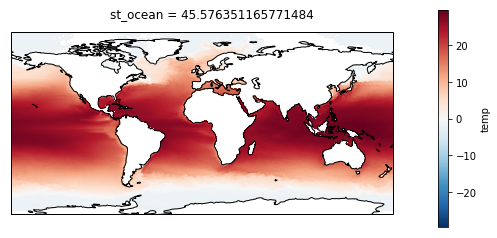

In [49]:
darray = cc.get_nc_variable('025deg_jra55v13_ryf8485_spinup_A','ocean.nc','temp',n=1,time_units='days since 1700-01-01')
temp = darray.mean('time').sel(st_ocean=50,method='nearest') - 273.19
plt.figure(figsize=(9,4))
ax = plt.axes(projection=ccrs.PlateCarree())
temp.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),x='xt_ocean', y='yt_ocean')
ax.coastlines()

### 3.2 Functionising